In [3]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 불러오기
train_data = pd.read_table('./naver/ratings_train.txt')
test_data = pd.read_table('./naver/ratings_test.txt')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
from eunjeon import Mecab # 토크나이저

In [6]:
tokenizer = Mecab() #토크나이저 지정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] #제외할 목록 조사 등
def load_data(train_data, test_data, num_words=10000): #num_words = 빈도수 기준으로 몇개까지 사용할 것인지
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화 메캡 사용.
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X) # X_train 만듬
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) # most_comon은 빈도수 n개만큼. 여기선 4개를 빼고 밑에 4개를 채워넣음.
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} #enumerate 인덱스의 번호와 원소 튜플로 반환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
#maxlen 설정을 위해 우선 학습셋과 검증셋 통합
total_data_text = list(X_train) + list(X_test)

#토큰을 하나씩 뽑아서 길이 확인
num_tokens = [len(tokens) for tokens in total_data_text]
#계산을 용이하게 하기위해 넘파이 어레이로 변경
num_tokens = np.array(num_tokens)
# 만든 array를 통해 기본적인 상황 체크 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.972842084785936
문장길이 최대 :  116
문장길이 표준편차 :  12.843357707480491
pad_sequences maxlen :  41
전체 문장의 0.9342732378070944%가 maxlen 설정값 이내에 포함됩니다. 


In [24]:
x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'pre면 배열 중 앞에 패딩,post면 뒤. 디폴트는 pre
                                                       maxlen=maxlen)
print(x_train.shape)

(146182, 41)


In [9]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   #LSTM 벡터의 차원수 8은 변경가능
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [10]:
# validation set 50000건 분리
x_val = x_train[:50000]   
y_val = y_train[:50000]
# validation set을 제외한 나머지 
partial_x_train = x_train[50000:]  
partial_y_train = y_train[50000:]
print(partial_x_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=20  
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs, #학습 시도 횟수
                    batch_size=512, #한번에 처리할 데이터 갯수
                    validation_data=(x_val, y_val), #테스트셋
                    verbose=1) #모델학습 진행상황 표시

Epoch 1/20
188/188 [==============================] - 8s 32ms/step - loss: 0.6362 - accuracy: 0.6066 - val_loss: 0.3992 - val_accuracy: 0.8300
Epoch 2/20
188/188 [==============================] - 4s 22ms/step - loss: 0.3607 - accuracy: 0.8522 - val_loss: 0.3569 - val_accuracy: 0.8472
Epoch 3/20
188/188 [==============================] - 4s 22ms/step - loss: 0.3196 - accuracy: 0.8697 - val_loss: 0.3576 - val_accuracy: 0.8457
Epoch 4/20
188/188 [==============================] - 4s 21ms/step - loss: 0.3057 - accuracy: 0.8766 - val_loss: 0.3648 - val_accuracy: 0.8421
Epoch 5/20
188/188 [==============================] - 4s 21ms/step - loss: 0.2921 - accuracy: 0.8828 - val_loss: 0.3596 - val_accuracy: 0.8436
Epoch 6/20
188/188 [==============================] - 4s 21ms/step - loss: 0.2868 - accuracy: 0.8859 - val_loss: 0.3662 - val_accuracy: 0.8444
Epoch 7/20
188/188 [==============================] - 4s 21ms/step - loss: 0.2829 - accuracy: 0.8875 - val_loss: 0.3721 - val_accuracy: 0.8430

In [12]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4695 - accuracy: 0.8315
[0.46951568126678467, 0.8315194249153137]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


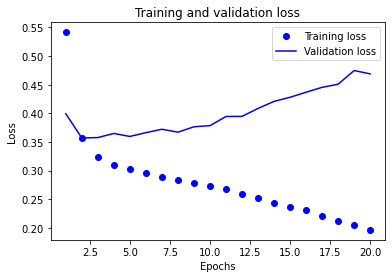

In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
#위의 그래프를 보면 2.5이후 과적합이 나타나는 걸 볼 수 있음

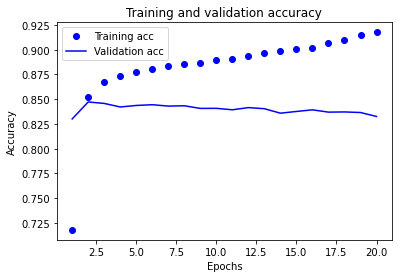

In [15]:
plt.clf()   # 그림을 초기화합니다
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
#traning acc는 epochs가 늘어날수록 개선되지만 val acc는 거의 변하지 않음을 볼 수 있음.

In [17]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = './aiffel/word2vec.txt'
f = open(word2vec_file_path, 'w', -1, 'utf-8')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)


In [18]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.02097796, -0.05724523,  0.02577771,  0.17089361,  0.02193356,
       -0.05802457,  0.0018189 , -0.01071164,  0.03152116, -0.06015264,
        0.02591933, -0.00077448, -0.0021473 , -0.07553603, -0.05311358,
        0.02325409], dtype=float32)

In [23]:
word_vectors.similar_by_word("사랑")

[('마을', 0.9657961130142212),
 ('울린', 0.956697940826416),
 ('삶', 0.9559673070907593),
 ('언젠가', 0.9451871514320374),
 ('풀리', 0.9449841976165771),
 ('고급', 0.9449582099914551),
 ('9', 0.944034218788147),
 ('요괴', 0.9434374570846558),
 ('어울려', 0.9409751892089844),
 ('멋지', 0.9404110312461853)]